# Working with Raster Data

<br>

In this tutorial you will learn raster-specific pre-processing and analysis steps such as resampling  and reclassification. You will learn how to execute local operations of map algebra in raster calculator and how to summarise raster data using zonal statistics. You will also learn how to create distance, slope and aspect rasters.

We will keep working on siting a solar power station in Zambia, this time using raster data – including the solar power potential.

We will use land cover, and elevation to further optimise the location of the facility: we’d like to avoid cutting trees or building in a swamp. We’d also like to avoid the steepest slopes.

Finally, using solar potential raster (Global Horizontal Irradiance in kWh/m2/year) we will be able to estimate the power which may be available in our selected zones.


<br>

## Analysis Preparation

### Imports

All of these libraries should have been previously installed during the environment set-up, if they have not been installed already you can use `install.packages(c("sf", "ggplot2"))`. The exception is `cartomisc` which we'll install now.

In [28]:
library(sf) # for handling spatial features
library(dplyr) # used for data manipulation
library(raster) # useful in some spatial operations
library(ggplot2) # for plotting
library(zeallot) # used for unpacking variables

source('../scripts/helpers.R') # helper script, note that '../' is used to change into the directory above the directory this notebook is in

<br>

### Loading Data

We'll start by again checking to see if we need to download any data

In [176]:
download_data()

<br>

Then by reading in a shapefile for Zambia

In [134]:
df_zambia <- read_sf('../data/zambia/zambia.shp')

df_zambia

ID,CODE,COUNTRY,areaQ,geometry
<chr>,<chr>,<chr>,<dbl>,<POLYGON [m]>
761,ZAM,Zambia,777795418089,"POLYGON ((716452.6 8516873,..."


<br>

We'll also load land cover, solar radiance, and elevation raster data from .tif files

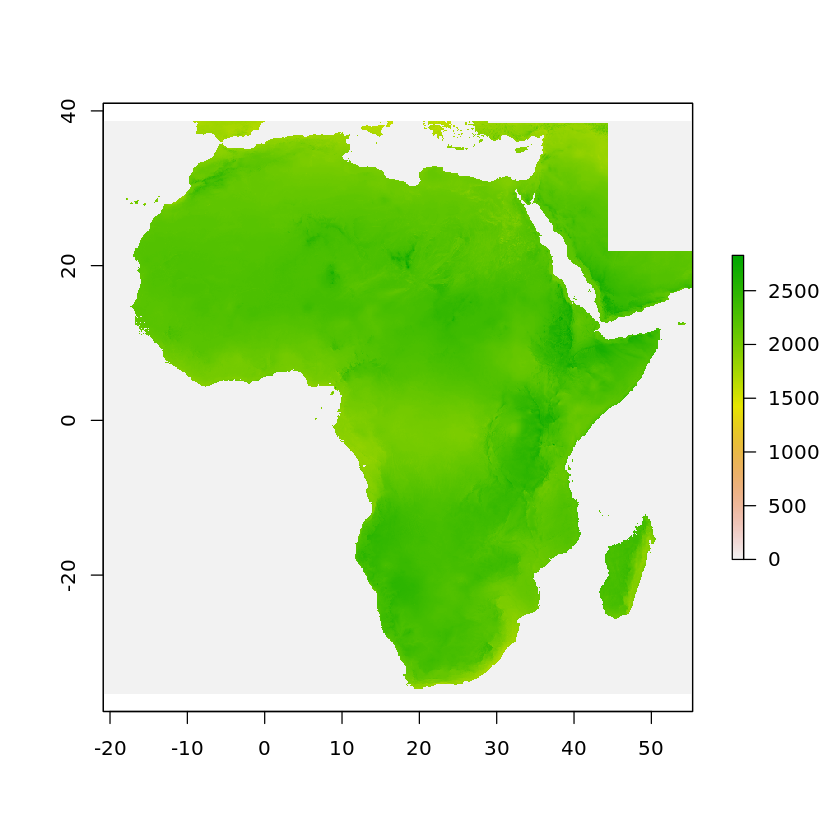

In [177]:
solar <- raster('../data/africa/solar.tif')
land_cover <- raster('../data/africa/land_cover.tif')
elevation <- raster('../data/africa/elevation.tif')

plot(solar)

<br>

### Raster Cropping & Masking

In the same way you can clip vectors with a “cookie cutter” outline you can also clip rasters. 

`crop` allows us to clip the raster to the extents of the vector geometry, similar to cropping an image.

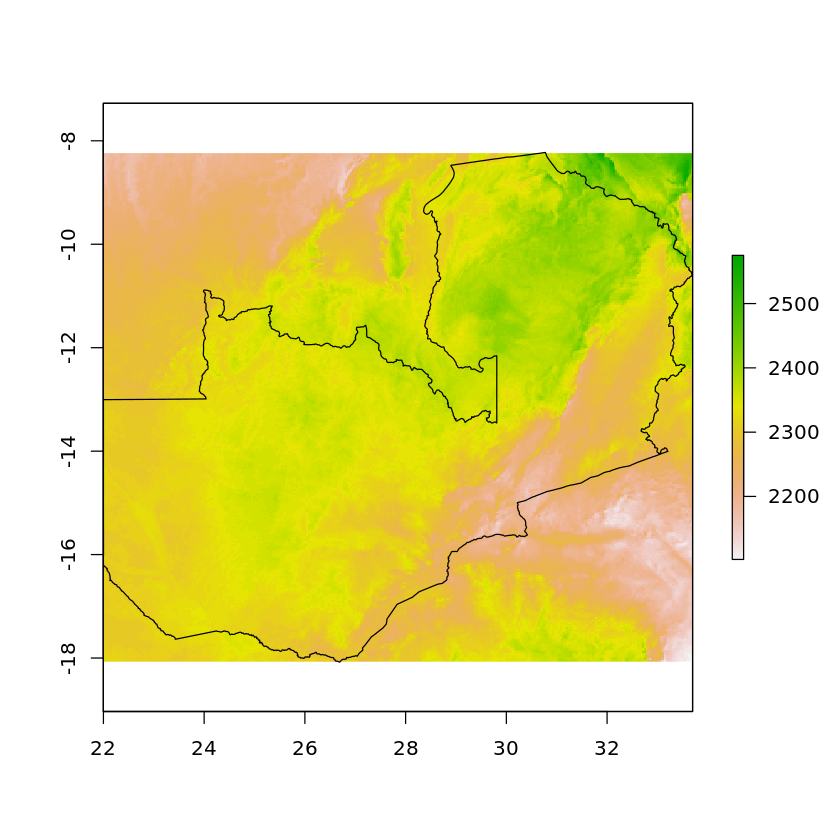

In [5]:
df_zambia_4326 <- st_transform(df_zambia, crs=st_crs(solar))
solar_zambia <- crop(solar, df_zambia_4326)

plot(solar_zambia)
plot(df_zambia_4326['geometry'], add=TRUE)

<br>

If we want to remove all values that are outside of Zambia's borders we can use `mask`

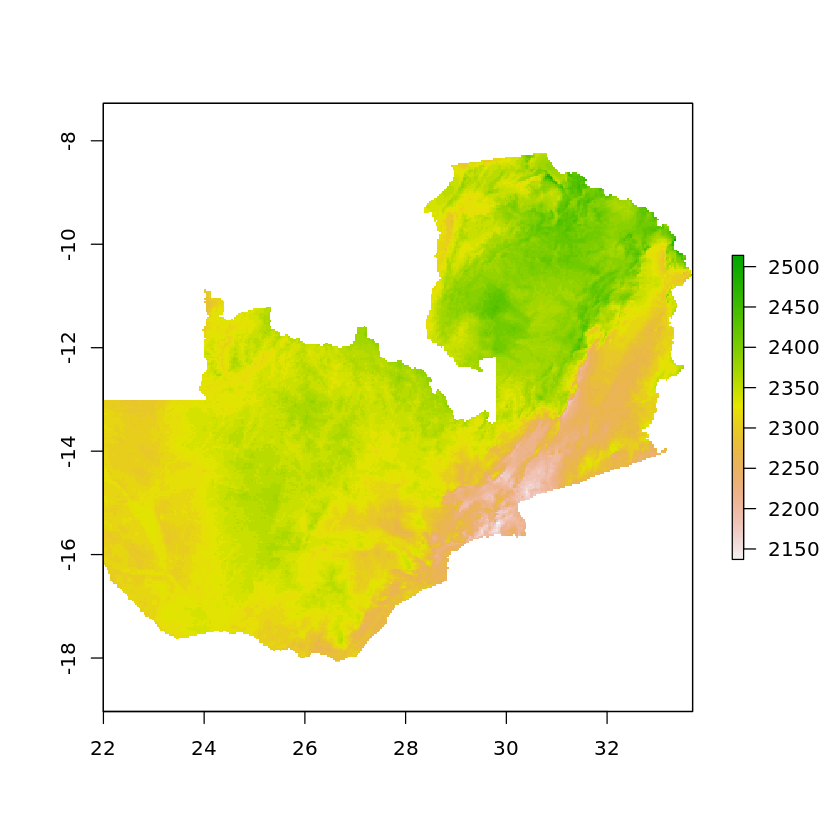

In [6]:
masked_solar_zambia <- mask(solar_zambia, df_zambia_4326)

plot(masked_solar_zambia)

<br>

It's worth carrying out the crop before the mask as otherwise the returned raster will still go to the extent of the original data, e.g.

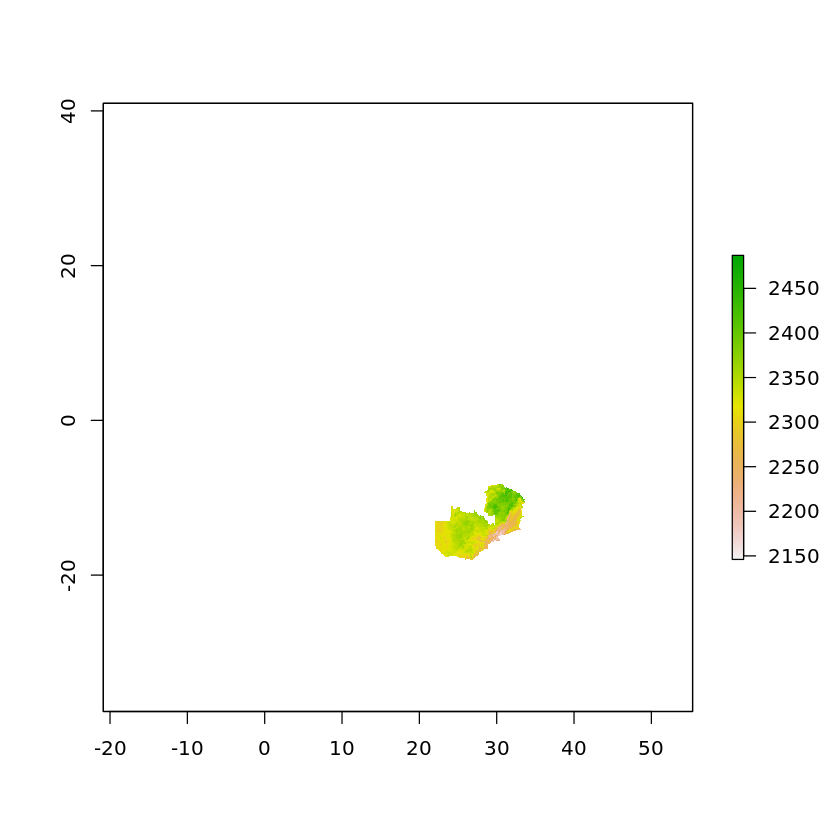

In [7]:
plot(mask(solar, df_zambia_4326))

<br>

Whilst the existing mask function is really useful it doesn't give us all of the fine-grained control we might require. For example a common area for fine-tuning raster masks is deciding the cut-off point for when cells are inside/outside the border - should we include all cells that the border touches or only the ones that fall fully inside it?

To enable this flexibility we'll create our own raster mask. 

First we'll rasterize the zambia polygon, passing an example raster which will be used to construct the grid, as well as the optional argument `getCover`. By setting `getCover` to `TRUE` the values of the returned raster will be the percentage of the cell that falls inside the polygon. We'll also set all cells that do not touch the polygon to `NA`.

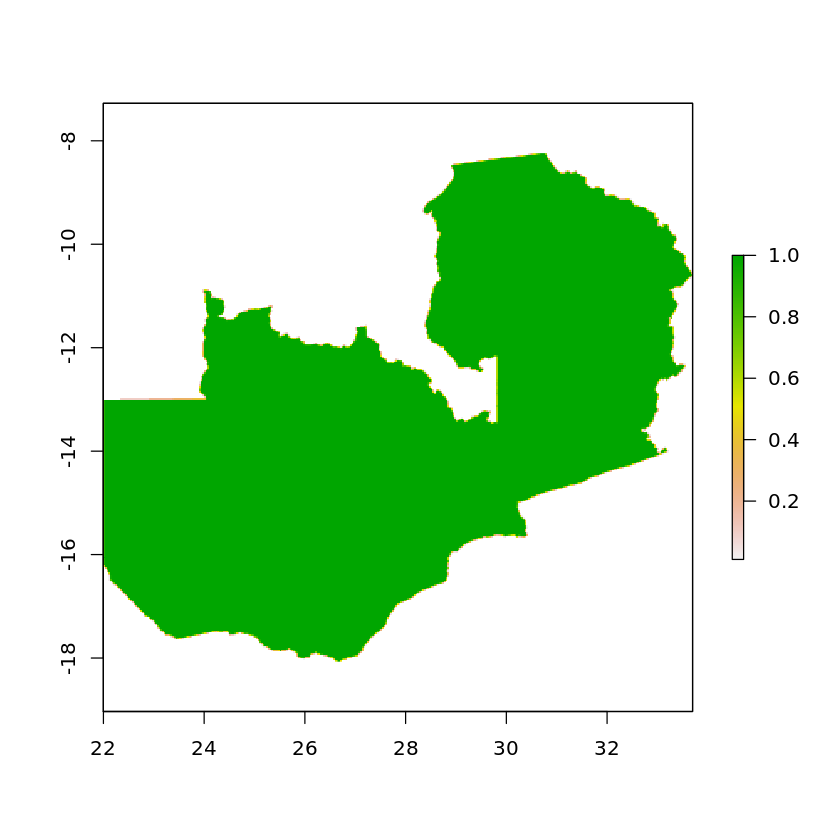

In [8]:
zambia_raster_mask <- rasterize(df_zambia_4326, solar_zambia, getCover=TRUE)
zambia_raster_mask[zambia_raster_mask==0] <- NA

plot(zambia_raster_mask) 

<br>

For plotting with Ggplot, we'll convert our raster into a tibble and also remove any `NA` values.

In [9]:
tb_zambia_raster_mask <- gplot_data(zambia_raster_mask)
tb_zambia_raster_mask <- subset(tb_zambia_raster_mask, !is.na(tb_zambia_raster_mask$value))

head(tb_zambia_raster_mask)

x,y,value,variable
<dbl>,<dbl>,<dbl>,<chr>
30.44767,-8.262019,0.09,layer
30.49581,-8.262019,0.19,layer
30.54396,-8.262019,0.34,layer
30.59210,-8.262019,0.58,layer
30.64025,-8.262019,0.73,layer
30.68840,-8.262019,0.97,layer


<br>

We're now ready to visualise the raster mask alongside the vector, we can see how the cells that are only slightly touched by the vector are darker with lower coverage percentages.

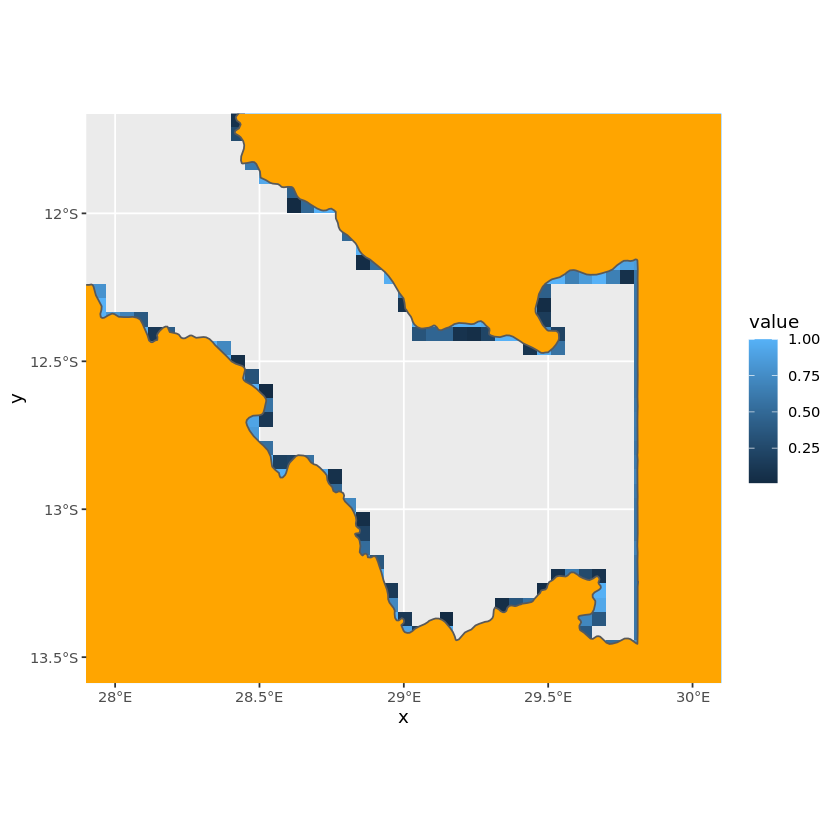

In [10]:
ggplot() +
    geom_tile(data=tb_zambia_raster_mask, aes(x=x, y=y, fill=value)) + 
    geom_sf(data=df_zambia_4326, fill='orange') +
    coord_sf(xlim=c(28, 30), 
             ylim=c(-13.5, -11.75))

<br>

We want to use all of the raster cells that touch the country so can directly use the raster mask we just created. However, if we only wanted cells that fully lay inside the border we could set all values less than one to NA, e.g. using `zambia_raster_mask[zambia_raster_mask<1] <- NA`.

N.b. we use the same `mask` function regardless of whether the masking feature is a raster or vector.

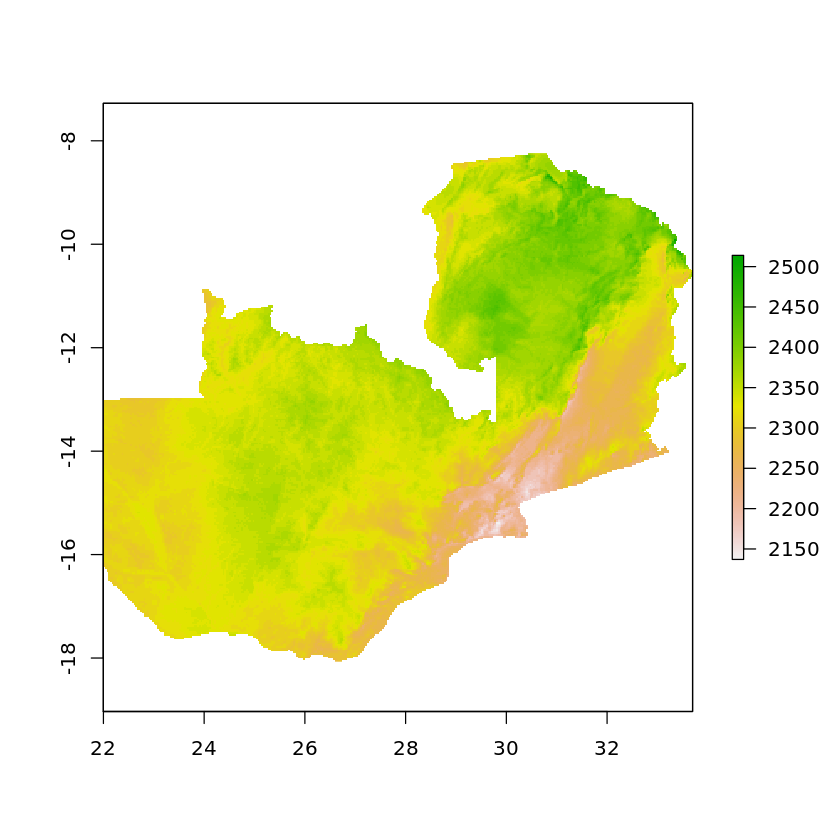

In [11]:
masked_solar_zambia <- mask(solar_zambia, zambia_raster_mask)

plot(masked_solar_zambia)

<br>

We'll tie a number of these steps together in a single function:
* Reprojecting the vector data to the same CRS as the raster
* Cropping the raster to tthe vector extents
* Rasterising the vector and returning the cover percentage value
* Setting all cells below the defined coverage percentage to NA
* Finally masking the raster

We'll then apply these to both the `land_cover` and `elevation` raster datasets.

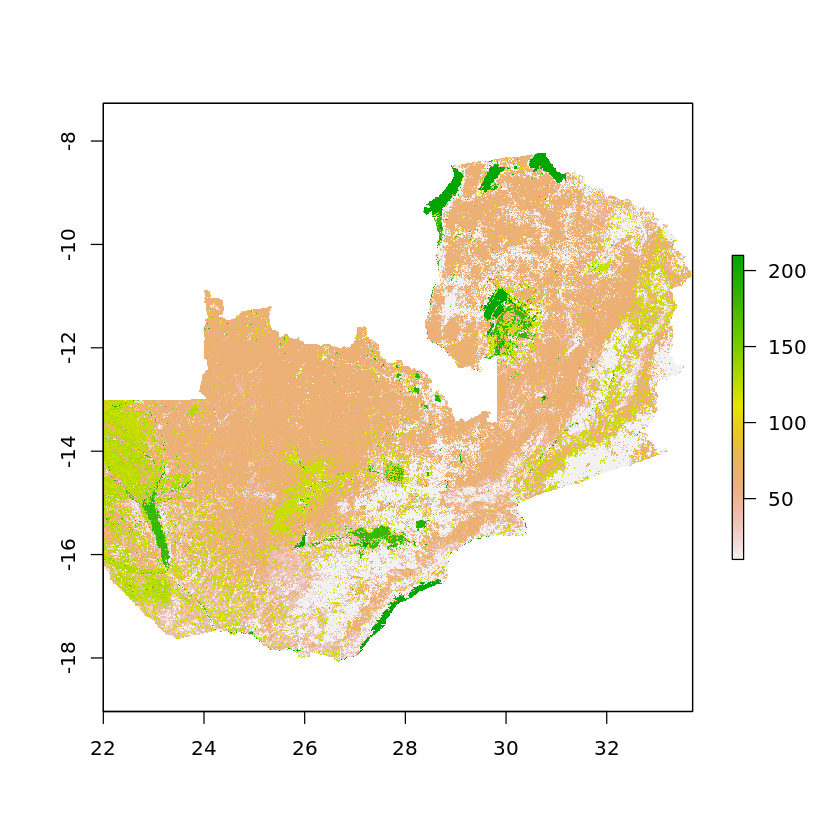

In [180]:
quick_mask_raster <- function(raster_data, masking_vector){
    masking_vector <- st_transform(masking_vector, st_crs(raster_data))
    cropped_raster_data <- crop(raster_data, masking_vector)
    masked_raster_data <- mask(cropped_raster_data, masking_vector)
    
    return(masked_raster_data)
}

mask_raster <- function(raster_data, masking_vector, min_mask_cover=1){
    # Ensuring masking_vector is in the same proj
    masking_vector <- st_transform(masking_vector, st_crs(raster_data))
    
    # Cropping raster to masking_vector extents
    cropped_raster <- crop(raster_data, masking_vector)
    
    # Creating raster mask according to specified cover percentage
    raster_mask <- rasterize(masking_vector, cropped_raster, getCover=TRUE)
    raster_mask[raster_mask<min_mask_cover] <- NA

    # Masking the raster
    masked_raster <- mask(cropped_raster, raster_mask)
    
    return(masked_raster)
}

masked_elevation <- quick_mask_raster(elevation, df_zambia)
masked_land_cover <- quick_mask_raster(land_cover, df_zambia)

plot(masked_land_cover)

<br>

To free up some RAM we can now delete the original unmasked raster objects

In [105]:
rm(solar, land_cover, elevation)

<br>

#### Questions

##### Masking Based on Grid Distance

Using the masking techniques from this tutorial and the buffering techniques from the vector tutorial you should mask the solar dataset based on whether the cells are within 10km of the Zambian electricity grid.

In [ ]:
# 

<br>

### Reprojecting Rasters

Now let’s transform the rasters to match our selected coordinate system. The `raster` package contains a useful function called `projectRaster` that lets us transform the raster from one CRS into another, in this case we'll reproject to UTM 35S.

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded ellps unknown in CRS definition: +proj=utm +zone=35 +south +a=6378249.145 +b=6356514.96639875 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum unknown in CRS definition,
 but +towgs84= values preserved”


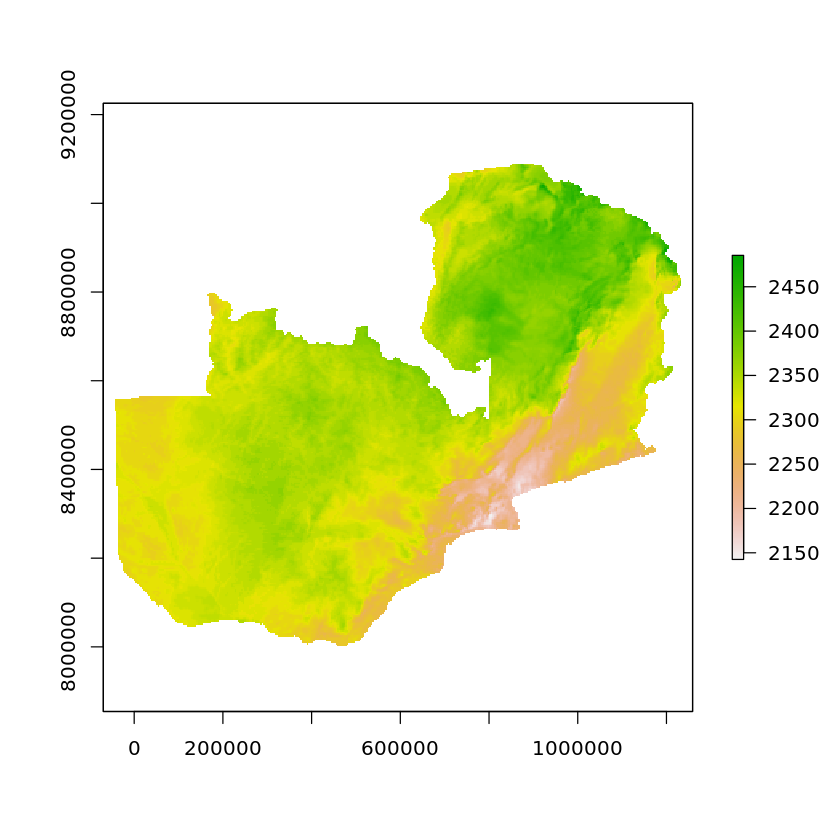

In [26]:
crs = '+proj=utm +zone=35 +south +a=6378249.145 +b=6356514.966398753 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs '
zambia_solar_reproj = projectRaster(masked_solar_zambia, crs=crs)

plot(zambia_solar_reproj)

<br>

Whilst the country's shape may not appear to change we can see that the axis definitely have compared to the original data.

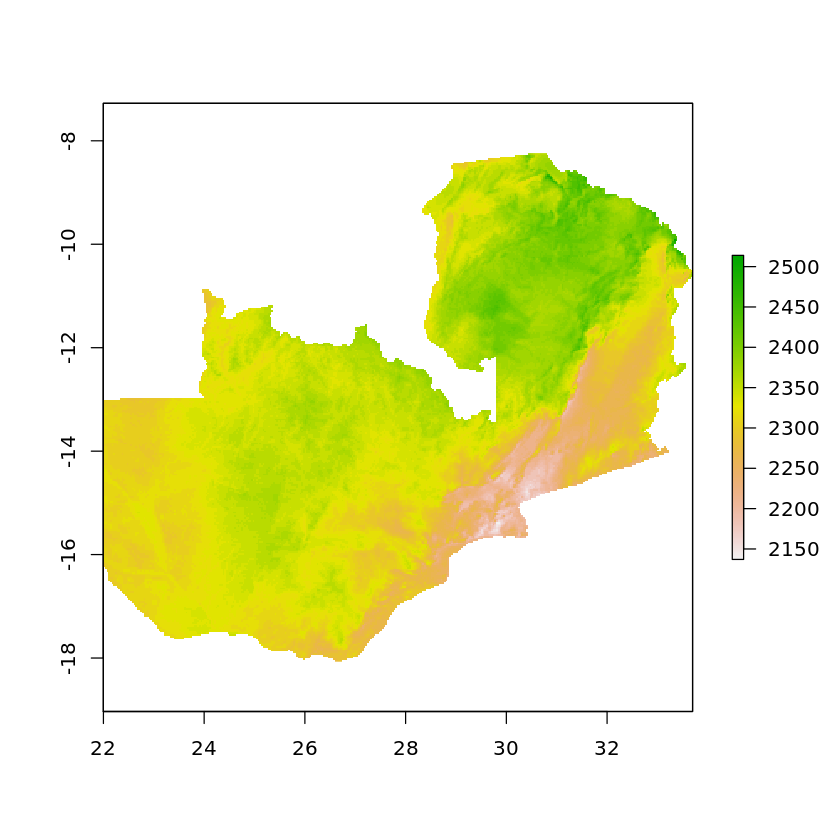

In [29]:
plot(masked_solar_zambia) 

<br>

Note that we can use a number of different algorithms when reprojecting the data. `ngb` (nearest neighbor) is very useful when working with categorical variables as it ensures that all values returned are values that existed in the original dataset. `bilinear` (bilinear interpolation) is more useful when working with continuous data, it is carried out by first using linear interpolation in one direction, then using it again in the other direction. Note that by default bilinear interpolation will be used.

As land-use is a categorical raster we'll use `ngb` and conversely for elevation we'll use `bilinear`.

In [34]:
zambia_elevation_reproj = projectRaster(masked_elevation, crs=crs, method='bilinear')
zambia_land_use_reproj = projectRaster(masked_land_cover, crs=crs, method='ngb')

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded ellps unknown in CRS definition: +proj=utm +zone=35 +south +a=6378249.145 +b=6356514.96639875 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum unknown in CRS definition,
 but +towgs84= values preserved”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded ellps unknown in CRS definition: +proj=utm +zone=35 +south +a=6378249.145 +b=6356514.96639875 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum unknown in CRS definition,
 but +towgs84= values preserved”


<br>

### Raster Reclassification

In this section we'll reclassify the land cover raster, firstly to simplify it, then to create a binary raster layer for whether or not the land is suitable to build power plants on.

We'll begin by reading in the land cover classes csv.

In [49]:
df_land_cover_classes <- read.csv('../data/africa/land_cover_classes.csv', header=TRUE)

head(df_land_cover_classes)

,ID,reclass,category,suitability
,<int>,<int>,<chr>,<int>
1,0,0,no_data,0
2,10,1,crop,1
3,11,2,grass,1
4,12,3,tree,0
5,20,1,crop,1
6,30,1,crop,1


<br>

We want to map from the `ID` classes to the new `reclass` categories, we can do this by specifying them as `by` and `which` in the `subs` function.

We can see in the new `zambia_land_use_reclass` object that we only have values ranging from 1-7 now. 

In [50]:
zambia_land_use_reclass <- subs(zambia_land_use_reproj, df_land_cover_classes, by='ID', which='reclass')

zambia_land_use_reclass

Warning message in if (is.factor(object)) {:
“the condition has length > 1 and only the first element will be used”


class      : RasterLayer 
dimensions : 3602, 4301, 15492202  (nrow, ncol, ncell)
resolution : 301, 307  (x, y)
extent     : -52854.47, 1241747, 7986847, 9092661  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=35 +south +a=6378249.145 +b=6356514.96639875 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs 
source     : memory
names      : reclass 
values     : 1, 7  (min, max)


<br>

When we carry out this reclassification we're also telling R that we want to define the new `RasterLayer` as a categorical variable, these are linked to their values via a Raster Attribute Table (RAT). In order to plot these categorical raster layers we must `ratify` the objects before plotting.

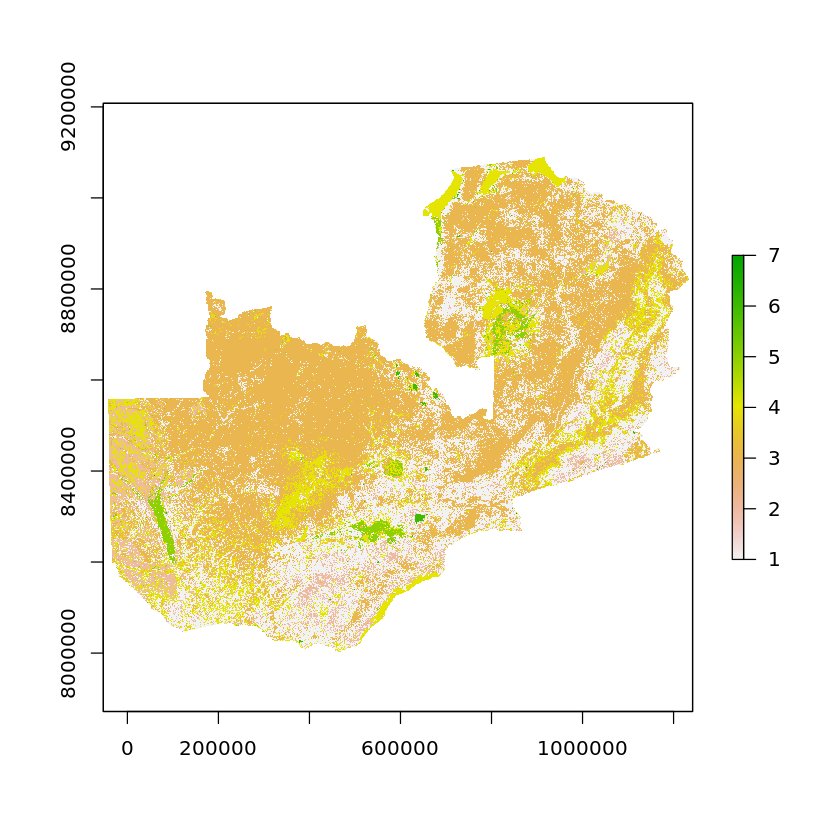

In [63]:
plot(ratify(zambia_land_use_reclass))

<br>

Now let's take the reclassification even further. Assume we want to locate our powerplant at a site which has no tree cover - water, built-up areas, and ice are also not the best places to build the facility.

We've included in the reclassfiication dataframe a column called `suitability`, for unsuitable land this value is 0, whereas it is 1 when the land is suitable for a power plant.


In [52]:
zambia_land_use_suitability <- subs(zambia_land_use_reproj, df_land_cover_classes, by='ID', which='suitability')

zambia_land_use_suitability

Warning message in if (is.factor(object)) {:
“the condition has length > 1 and only the first element will be used”


class      : RasterLayer 
dimensions : 3602, 4301, 15492202  (nrow, ncol, ncell)
resolution : 301, 307  (x, y)
extent     : -52854.47, 1241747, 7986847, 9092661  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=35 +south +a=6378249.145 +b=6356514.96639875 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs 
source     : memory
names      : suitability 
values     : 0, 1  (min, max)


<br>

When we visualise this the green areas are those that are suitable to site a plant on whilst the white areas are not.

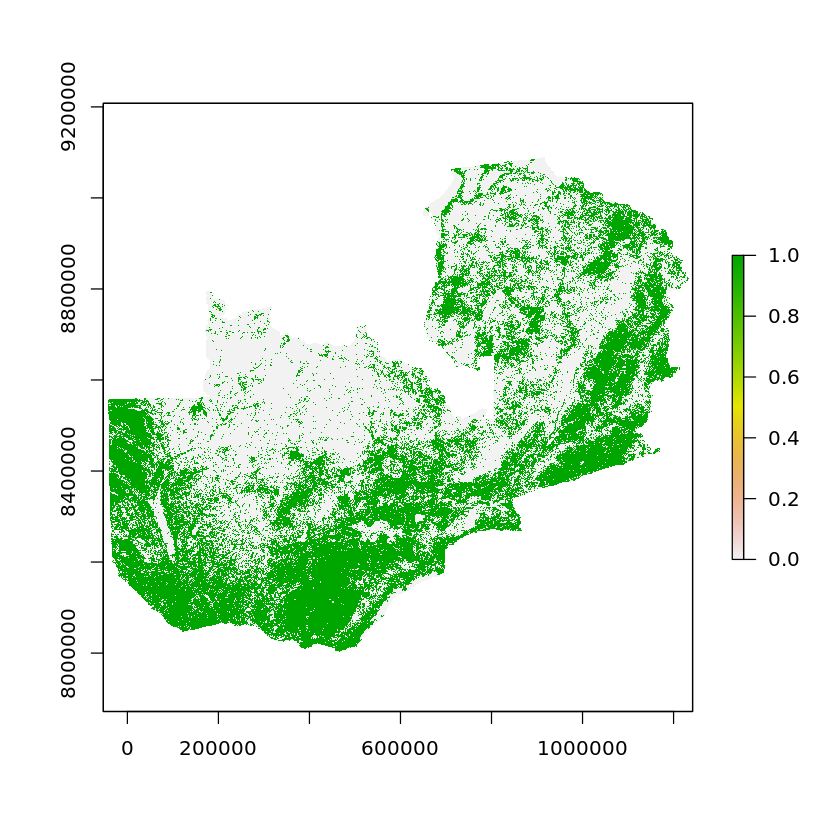

In [64]:
plot(ratify(zambia_land_use_suitability))

<br>

#### Questions

##### Suitable Areas for Floating Solar/Offshore Wind

Plot the suitable areas for floating solar and offshore wind, you can use any land cover category that is specified as 'water'.

In [ ]:
# 

<br>

### Raster Resampling

In order to combine data from two or more rasters their cells need to be perfectly aligned. This leads to the need for resampling of the rasters. The resampling operation has two components: resizing and realignment of raster cells. 

Let’s resample the land cover suitability and solar potential to match the resolution and alignment of the altitude raster. To do this we can use the `resample` function which has the same algorithm method options as `projectRaster`.

In [72]:
zambia_land_use_suitability_regrid <- resample(zambia_land_use_suitability, zambia_elevation_reproj, method='ngb')
zambia_solar_reproj_regrid <- resample(zambia_solar_reproj, zambia_elevation_reproj, method='bilinear')

zambia_land_use_suitability_regrid

class      : RasterLayer 
dimensions : 1207, 1441, 1739287  (nrow, ncol, ncell)
resolution : 903, 922  (x, y)
extent     : -55913.23, 1245310, 7983172, 9096026  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=35 +south +a=6378249.145 +b=6356514.96639875 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs 
source     : memory
names      : suitability 
values     : 0, 1  (min, max)


<br>

One way to check that the resampling has worked is to confirm that the dimensions of each object are the same. For this we can use the `dim` function.

In [75]:
dim(zambia_elevation_reproj) == dim(zambia_land_use_suitability_regrid)

[1] TRUE TRUE TRUE

<br>

At this point stop and have a think about some of the issues with resampling rasters:
* What would have happened if we'd used the default resampling method with the land_cover data? 
    * Why wouldnt this have been ideal?
* What are some of the drawbacks of resampling to a raster that is at a much higher resolution? 
    * Is it objectively better to up or down-sample? 
    * How does this change depending on the problem your solving?

<br>

### Raster Algebra

In many ways we can view a raster as a normal mathematical matrix over which we can perform calculations and statistical operations. This is useful as we can use mathematical formulae to recalculate raster cell values.

A detailed list of the available operations can be found at <a href="https://rspatial.org/raster/spatial/8-rastermanip.html#raster-algebra">rspatial.org</a>

> Many generic functions that allow for simple and elegant raster algebra have been implemented for `Raster` objects, including the normal algebraic operators such as `+`, `-`, `*`, `/`, logical operators such as `>`, `>=`, `<`, `==`, `!` and functions like `abs`, `round`, `ceiling`, `floor`, `trunc`, `sqrt`, `log`, `log10`, `exp`, `cos`, `sin`, `atan`, `tan`, `max`, `min`, `range`, `prod`, `sum`, `any`, `all`. In these functions you can mix raster objects with numbers, as long as the first argument is a raster object.

For example, if we wanted a raster with monthly solar power potential rather than annual we could divide all cell values by 12.

In [74]:
zambia_solar_monthly <- zambia_solar_reproj_regrid/12

<br>

When two rasters are using the same CRS and are placed on the same grid (as we did in the resampling step), we can do mathematical operations using both of them. A common area this is used is in raster masking, where we can multiply a binary raster (TRUE/FALSE) by another raster to return only the values where the binary raster was TRUE. 

Here we'll mask the solar data based on the land cover suitability. The output solar potential raster will be either 0 where power cannot be obtained, or the value of potential (in kWh/m2/year), where the land cover conditions are met.

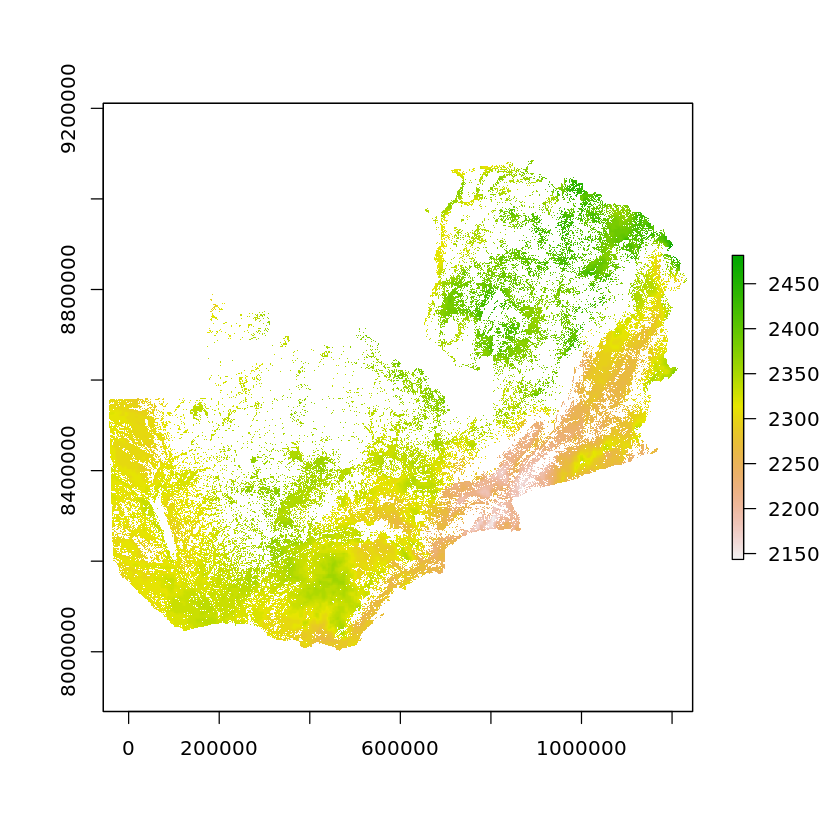

In [80]:
zambia_suitable_solar <- zambia_solar_reproj_regrid * zambia_land_use_suitability_regrid
zambia_suitable_solar[zambia_suitable_solar==0] <- NA

plot(zambia_suitable_solar)

<br>

#### Questions

##### Estimating Resampling Errors

When doing spatial analysis it is often useful to compare the difference between your results depending on how a spatial method is used. In this task you must determine the percentage difference between the resampled solar potential depending on whether bi-linear or ngb is used.

In [ ]:
# 

<br>

### A GIS Tale: Rasterization & Back Again

When working with spatial data, typically, you will not work with only raster or only vector datasets. However, to carry out spatial operations between datasets we often require them to be in the same format. For this reason it is highly important that you udnerstand how we can convert from Raster -> Vectors and vice versa.

Before we do the rasterization we'll load a dataset that will be more useful in explaining this visually - the country shapefiles. We'll then create a column for the area of each country that will be used as the values in the final raster.

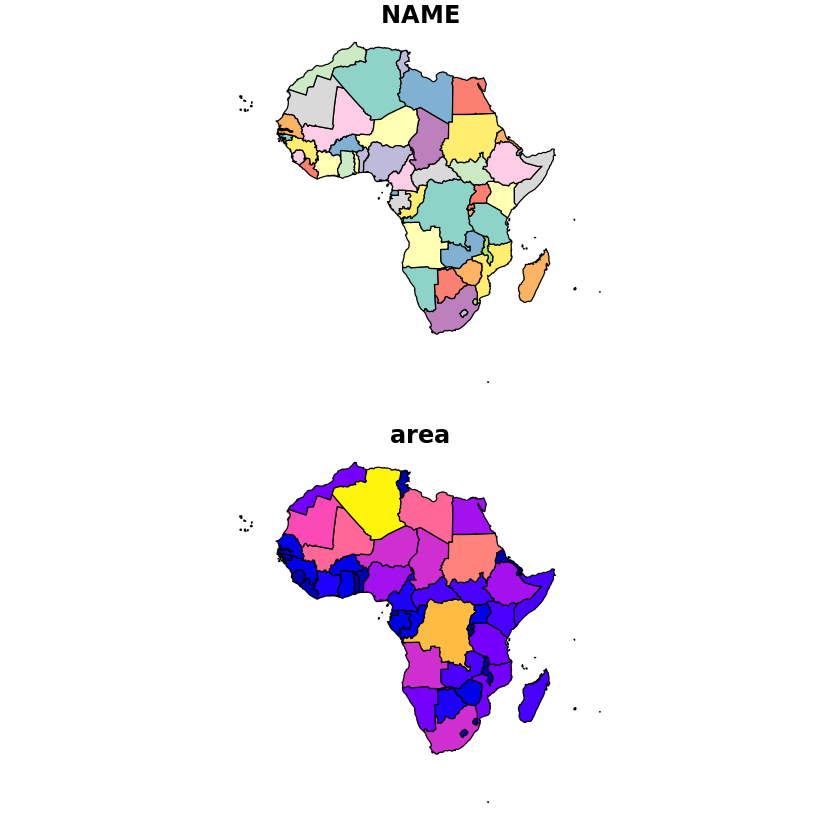

In [102]:
df_countrys <- read_sf('../data/africa/countries.shp')
df_countrys <- st_transform(df_countrys, st_crs(zambia_solar_reproj_regrid))

df_countrys$area <- st_area(df_countrys)

plot(df_countrys)

<br>

The `raster` package contains the function `rasterize` which we'll use to convert from the country polygons to a raster. We provide it the vector objects, the raster grid we wish to rasterize onto, as well as the column that contains the values we wish to be used in the raster.

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded ellps unknown in CRS definition: +proj=utm +zone=35 +south +a=6378249.145 +rf=293.466307699995 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum unknown in CRS definition,
 but +towgs84= values preserved”
Warning message in showSRID(SRS_string, format = "PROJ", multiline = "NO"):
“Discarded ellps unknown in CRS definition: +proj=utm +zone=35 +south +a=6378249.145 +rf=293.466307699995 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs”
Warning message in showSRID(SRS_string, format = "PROJ", multiline = "NO"):
“Discarded datum unknown in CRS definition,
 but +towgs84= values preserved”


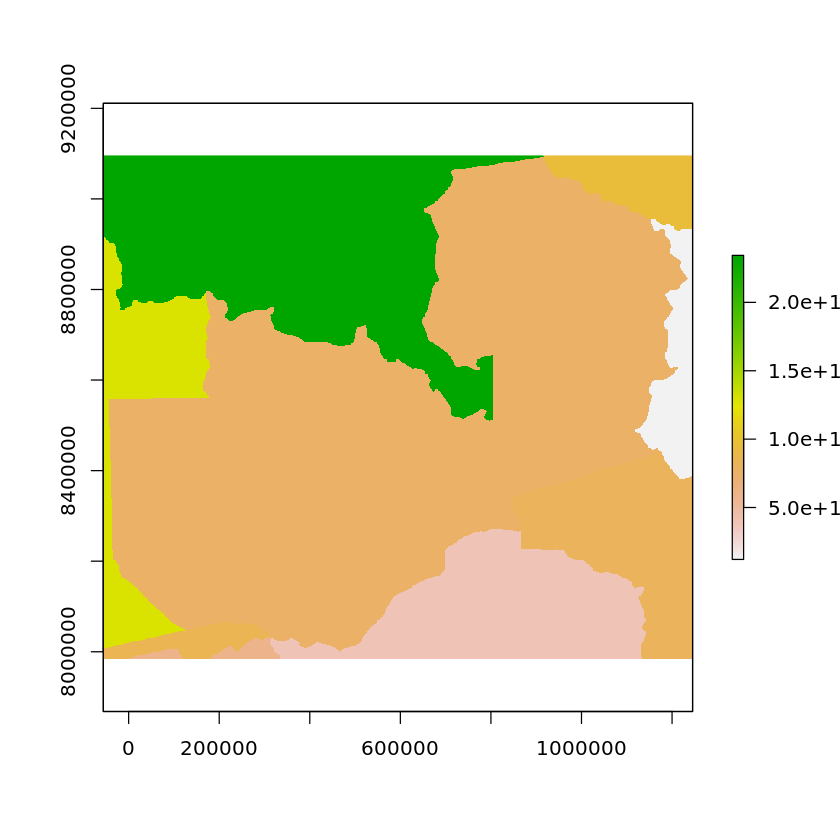

In [100]:
rasterized_country_areas <- rasterize(df_countrys, zambia_solar_reproj_regrid, 'area')

plot(rasterized_country_areas)

<br>

What happens if we want to go in the opposite direction though?

For that we can use the `polygonize` function which converts from rasters to polygons, we can set `dissolve` to `TRUE` which will group the resulting polygons based on the raster values (as long as the cells are adjacent).

In [121]:
polygonized_country_areas <- rasterToPolygons(rasterized_country_areas, dissolve=TRUE)

head(polygonized_country_areas)

,layer
,<dbl>
1,1.202574e+11
2,1.282970e+12
3,2.343754e+12
4,3.907642e+11
5,5.800564e+11
6,7.535634e+11


<br>

When plotted we can see that Zambia has been grouped correctly.

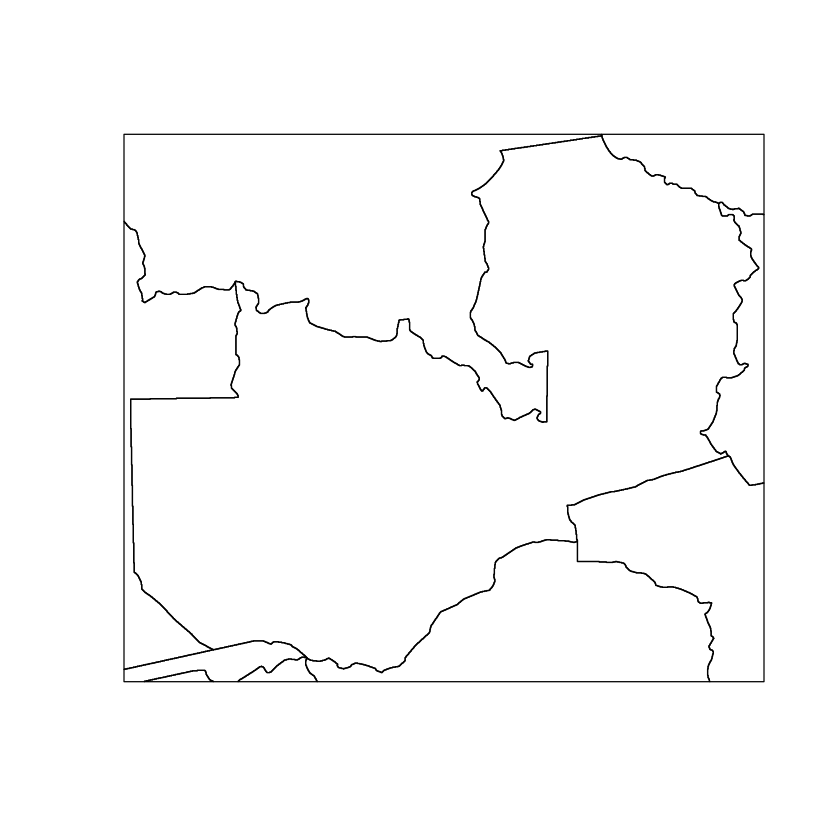

In [122]:
plot(polygonized_country_areas)

<br>

What problems do you think rasterization could raise?

<br>

### Zonal Statistics

*Zonal statistics* are statistics that are calculated for a given set of spatial zones and are typically defined by polygons/points based on values from a raster dataset. 

For example, summarising the solar power potential available in Zambia can be done using using the `extract` method which can be passed a function (in this case the mean). We could alternatively ask for other statistics such as the sum or distribution, in fact we can even pass our own custom functions. 

In [138]:
df_zambia_solar_mean <- extract(solar_zambia, df_zambia, fun=mean, df=TRUE)

df_zambia_solar_mean

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded ellps unknown in CRS definition: +proj=utm +zone=35 +south +a=6378249.145 +rf=293.4663077 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum unknown in CRS definition,
 but +towgs84= values preserved”
Warning message in showSRID(SRS_string, format = "PROJ", multiline = "NO"):
“Discarded ellps Clarke 1880 (Arc) in CRS definition: +proj=utm +zone=35 +south +a=6378249.145 +rf=293.4663077 +towgs84=-143,-90,-294,0,0,0,0 +units=m +no_defs”
Warning message in showSRID(SRS_string, format = "PROJ", multiline = "NO"):
“Discarded datum Arc_1950 in CRS definition”
Warning message in .local(x, y, ...):
“Transforming SpatialPolygons to the CRS of the Raster”


ID,solar
<int>,<dbl>
1,2331.507


<br>

Its not particularly interesting when we only have one Polygon to use for the zonal statistics, lets carry out some analysis of the solar potential at different cities. We'll first load the Africa-wide cities dataset and then filter it for Zambia (as described in the vector data tutorial), then get the solar potential calues at those points.

In [170]:
df_cities <- read_sf('../data/africa/cities.shp')
df_zambia_cities <- df_cities[which(st_intersects(st_transform(df_cities, st_crs(df_zambia)), df_zambia, sparse=FALSE)), ]

df_zambia_cities_solar <- extract(solar_zambia, df_zambia_cities, df=TRUE)

head(df_zambia_cities_solar)

,ID,solar
,<dbl>,<dbl>
1,1,2365
2,2,2382
3,3,2373
4,4,2417
5,5,2303
6,6,2330


<br>

Similarly we could extract the land cover classifications for each city as well.

In [175]:
head(extract(masked_land_cover, df_zambia_cities, df=TRUE))

,ID,land_cover
,<dbl>,<dbl>
1,1,120
2,2,190
3,3,190
4,4,11
5,5,190
6,6,190
